In [131]:
import numpy as np
import numpy.random as rd
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="darkgrid", palette="muted", color_codes=True)
%matplotlib inline

from matplotlib.colors import LinearSegmentedColormap

def generate_cmap(colors):
    """自分で定義したカラーマップを返す"""
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

gcm = generate_cmap(['lightblue', 'mediumblue', 'mediumblue','black', 'red', 'red', 'orangered'])

def one_hot_vector(label):
    """
    ラベルをone hot vector化
    """
    if label == 0:
        return [1.0,0.0]
    elif label == 1:
        return [0.0,1.0]

In [134]:
for package in [np, pd, matplotlib, sns]:
    print(package.__name__, package.__version__)


numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1
seaborn 0.7.1


In [76]:
# test data set
xmin, xmax = -6, 6
ymin, ymax = -6, 6
rd.seed(71)
n_data = 100

X =np.empty((n_data*4, 2))
for i ,m in enumerate([[-2, 2], [ 2,-2], [-2,-2], [ 2, 2]]):
    X[i*n_data:(i+1)*n_data] = rd.multivariate_normal(mean=m, cov=[[1,0],[0,1]], size=n_data)

Y = np.array([0]*n_data*2 + [1]*n_data*2)
idx = np.arange(len(X))
rd.shuffle(idx)
X = X[idx]
Y = Y[idx]

y = np.array(list(map(one_hot_vector,Y)))

In [122]:
df.head()

,x1,x2,label
0,3.498661,-1.804485,0.0
1,3.203520,2.465520,1.0
2,0.458317,2.598727,1.0
3,1.881643,3.669868,1.0
4,-1.570572,1.319801,0.0


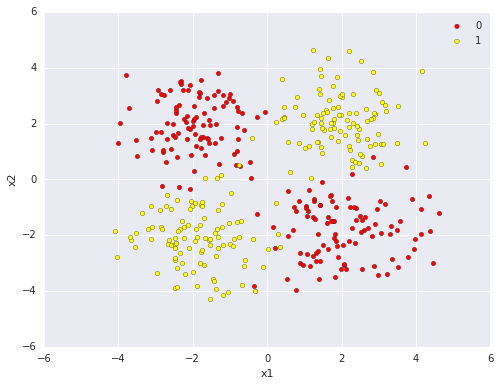

In [78]:
# Draw scatter plot
df = pd.DataFrame(np.c_[X, Y], columns=["x1", "x2", "label"])
plt.figure(figsize=(8,6))
ax = plt.subplot(111)

df[df.label==0].plot(kind='scatter', x='x1', y='x2',color='red', label='0', ax=ax)
df[df.label==1].plot(kind='scatter', x='x1', y='x2',color='yellow', label='1', ax=ax)

In [111]:
class FullConnected3layer(object):
    def __init__(self, n_in, n_hidden1, n_hidden2, n_out, alpha=0.1):  
        # 各層のノード数
        self.n_in = n_in
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_out = n_out
        
        # learning parameter
        self.alpha = alpha
        
        # parameter(乱数で初期化)
        self.W1 = rd.uniform(0, 1, size=(n_hidden1, n_in+1))
        self.W2 = rd.uniform(0, 1, size=(n_hidden2, n_hidden1+1))
        self.W3 = rd.uniform(0, 1, size=(n_out, n_hidden2+1))
        
        # 行列のサイズチェック用
        self.W1_shape = self.W1.shape
        self.W2_shape = self.W2.shape
        self.W3_shape = self.W3.shape

    def sigmoid(self, z):
        """
        シグモイド関数（活性化関数用）
        """
        return 1.0/ (1.0 + np.exp(-z) )

    def sigmoid_derivative(self, z):
        """
        シグモイド関数の微分
        """
        s = self.sigmoid(z)
        return s*(1.0-s)
    
    def forward(self, inputs, target):
        """
        順伝播
        """
        self.z1 = np.r_[[1], inputs].reshape(len(inputs)+1,1)
        #print("self.z1 ", self.z1.shape, self.z1 )
        #print("target:", target)
        self.target = target.reshape(len(target),1)

        self.u2 = np.dot(self.W1, self.z1)
        self.z2 = np.r_[np.ones(self.u2.shape[1]).reshape(1,self.u2.shape[1]), self.sigmoid(self.u2)]

        self.u3 = np.dot(self.W2, self.z2)
        self.z3 = np.r_[np.ones(self.u3.shape[1]).reshape(1,self.u3.shape[1]), self.sigmoid(self.u3)]

        self.u4 = np.dot(self.W3, self.z3).flatten()
        self.output = self.sigmoid(self.u4)
        
        loss = np.sum(np.c_[-np.log(self.output), -np.log(1-self.output)] * self.target.T)
        return self.output, loss
    

    def backward(self):
        """
        誤差逆伝播
        """
        
        # 出力層の誤差(n_out個): y - d [シグモイド関数の場合]
        #print("output, target, delta_3", self.output, self.target[0], self.output - self.target[0])
        delta_3 = self.output - self.target[0]

        f_dash_3 = np.r_[np.ones(self.u3.shape[1]).reshape(1,self.u3.shape[1]), self.sigmoid_derivative(self.u3)]
        delta_2 = delta_3 * f_dash_3.flatten() * self.W3.flatten()

        f_dash_2 = np.r_[np.ones(self.u2.shape[1]).reshape(1,self.u2.shape[1]), self.sigmoid_derivative(self.u2)]
        delta_1 = np.dot(delta_2[1:], (self.W2 * np.array([f_dash_2.flatten() for _ in range(self.W2.shape[0])])))

        delta_W3 = delta_3 * self.z3
        self.W3 = self.W3 - (self.alpha*delta_W3).flatten()
        assert self.W3_shape == self.W3.shape

        delta_W2 = np.dot(delta_2[1:].reshape(delta_2[1:].shape[0],1), self.z2.T)
        self.W2 = self.W2 - (self.alpha*delta_W2)
        assert self.W2_shape == self.W2.shape

        delta_W1 = np.dot(delta_1[1:].reshape(delta_1[1:].shape[0],1), self.z1.T)
        self.W1 = self.W1 - (self.alpha*delta_W1)
        assert self.W1_shape == self.W1.shape


def validate_network(model, X_test, y_test):
    print("===== test =====")
    scores = np.zeros(len(X_test))
    for i in range(len(X_test)):
        inputs = X_test[i]
        target = y_test[i]
        output, _ = model.forward(inputs, target)
        prediction = 1. if output>0.5 else 0.
        
        if prediction == target[0]:
            scores[i] = 1

    print('score is :', np.mean(scores))
    print('score is :', np.sum(scores))



# train the network
def train_network(model, X_train, y_train, tol=1e-05, n_iter=100000):
    print("===== train =====")
    history = []
    for cnt, x in enumerate(range(n_iter)):
        i = rd.randint(0,len(y_train)-1)
        inputs = X_train[i]
        target = y_train[i]
        output, loss = model.forward(inputs, target)
        model.backward()
        
        if x % 10000 == 0:
            print("iter:{}, loss:{}".format(cnt, loss))
            history.append([cnt, loss])
        if loss < tol:
            break
    df_hist = pd.DataFrame(history, columns=["cnt", "loss"])
    df_hist.index = df_hist.cnt
    return df_hist.drop("cnt", axis=1)

===== train =====
iter:0, loss:0.0031563349398688913
iter:10000, loss:0.22628466990573184
iter:20000, loss:0.002482119040604125
iter:30000, loss:0.00024700948180376796
iter:40000, loss:0.012942038208607029
iter:50000, loss:0.003705928105124443
iter:60000, loss:0.006627733158314002
iter:70000, loss:0.0005630120681275992
iter:80000, loss:0.0003250731342813878
===== test =====
score is : 0.939285714286
score is : 263.0


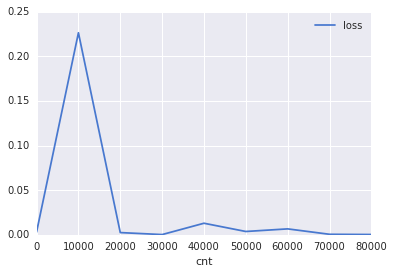

In [120]:
    
model = FullConnected3layer(n_in=2, n_hidden1=20, n_hidden2=10, n_out=1, alpha=0.1)

test_ratio = 0.3
train_size = int(test_ratio*len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test   = X[train_size:], y[train_size:]

history = train_network(model, X_train, y_train, tol=1e-05, n_iter=1000000 )
history.plot()
validate_network(model, X_test, y_test)

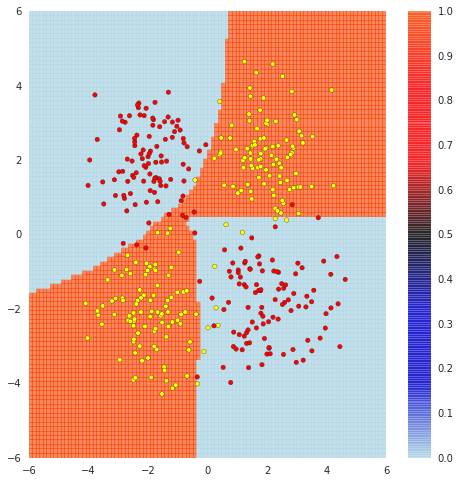

In [121]:
# 結果の描画
n_field = 101
x = np.linspace(xmin, xmax, n_field)
xx, yy = np.meshgrid(x, x)
z = []
for x1, x2 in zip(xx.flatten(), yy.flatten()):
    # 予測結果の出力
    output, loss = model.forward(np.array([x1, x2]), np.array([0]))
    z.append( 0 if output>0.5 else 1)
z = np.array(z).reshape(n_field, n_field)

# グラフ描画
plt.figure(figsize=(8,8))
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.pcolor(xx, yy, z, cmap=gcm, alpha=0.6)
plt.colorbar()
plt.scatter(X[:,0], X[:,1], c=Y, cmap=cm.autumn)